## WHAT'S THE PROBLEM WE ARE TRYING TO SOLVE?

We wish to quantify the risk of a portfolio where the timeseries of relevant asset values exhibits multicollinearity (look it up, e.g. [on wikipedia](https://en.wikipedia.org/wiki/Multicollinearity)).

In this example our domain is US yield to maturities and out portfolio is a position in the 7 year asset. We'll assume that the cheapest hedging instruments are at the 2y, 5y, 10y and 30y points.

The following code uses coppertop-bones.

<br>

*Concepts to become familiar with...* \
Risk - what is it? \
Risk-factors \
Model, modelling, model risk, modelling risk, implementation risk. \
Supervised vs unsupervised learning. What are the implications of each? \
Why are residuals important? \
Over-fitting, data splitting (& carve-out?), cross-validation, statistical tests.

<br>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import datetime, numpy as np, plotnine, statsmodels.api as sm, scipy.stats, sys
from numpy import linalg

from coppertop.pipe import *

from dm.core.types import btup, bframe, date, num, count as tCount, pylist, T1, txt, offset, pytuple, bstruct, \
    index, void, matrix, N
from dm.ols import OLSResult
from dm.jupyter import P9
from dm.panda import panda

from bones.core.sentinels import Void
from bones.lang.structs import tvarray

import dm.linalg.core, dm.pp, dm.panda, dm.jupyter, dm.plot
from broot import *
from broot import dm, seaborn

In [3]:
from bones.lang.metatypes import BTNom
from bones.lang.structs import tv

p9 = BTNom.ensure('p9').setCoercer(tv)

@coppertop
def PP(p: p9) -> p9:
    fig = p._v.draw(show=True)
    return p

array_ = (N**num)&tvarray
DATA_PATH = "./data"

<br>

#### UTILS

In [4]:
@coppertop
def residualsPlot(res:array_) -> P9:
    # res = res >> to >> (vec&tvarray)
    df = panda({'i':range(res >> count), 'res':res})
    answer = (plotnine.ggplot(df, plotnine.aes(x='i', y='res')) + plotnine.geom_point())
    answer = answer | P9
        # + p9.geom_line(color='lightgrey', size=0.25)
    return answer


@coppertop
def showStats(Y, X):
    return showStats(Y, X, dict(addIntercept=False))

@coppertop
def showStats(Y, X, options):
    lm = dm.stats.ols(Y, X, options)
    f'beta:    {(lm >> betaHat >> round(_, 3)).reshape(lm.K)}' >> PP #      resDoF: {lm.resDoF}' >> PP
    f't-stats: {lm >> tStats >> round(_, 3)} {lm >> tVals >> round(_, 3)}' >> PP
    f'F-stat:  {np.round(lm >> fStat, 1)} (5% is > {np.round(lm >> fCrit(_,0.05), 1)}), {np.round(lm >> fVal, 4)}    R2: {np.round(lm >> r2, 3)}   predR2: {np.round(dm.stats.predictedR2(Y, X, options), 3)}' >> PP
    return lm

@coppertop
def showResStats(x):
    av = np.mean(res); st = np.std(res); sk = scipy.stats.skew(res); ku = scipy.stats.kurtosis(res)
    des = scipy.stats.describe(res)
    skt = scipy.stats.skewtest(res)
    kut = scipy.stats.kurtosistest(res)
    sk = des.skewness if skt.pvalue < 0.05 else 0.0
    ku = des.kurtosis if kut.pvalue < 0.05 else 0.0
    f"res - mean: {format(des.mean, '.4f')}  std: {format(np.sqrt(des.variance), '.4f')}  skew: {format(sk, '.4f')}  kurt: {format(ku, '.4f')}" >> PP


<br>

#### LOAD DATA

In [5]:
renames = {
    'Date':'date', '1 Mo':'_1m', '2 Mo':'_2m', '3 Mo':'_3m', '6 Mo':'_6m', '1 Yr':'_1y', '2 Yr':'_2y', 
    '3 Yr':'_3y', '5 Yr':'_5y', '7 Yr':'_7y', '10 Yr':'_10y', '20 Yr':'_20y', '30 Yr':'_30y',
}

conversions = dict(
    date=to(_, (N**date)&tvarray, 'MM/DD/YY'), _1m=to(_,array_), _2m=to(_,array_), _3m=to(_,array_),
    _6m=to(_,array_), _1y=to(_,array_), _2y=to(_,array_), _3y=to(_,array_), _5y=to(_,array_),
    _7y=to(_,array_), _10y=to(_,array_), _20y=to(_,array_), _30y=to(_,array_),
)

path = DATA_PATH
filename = 'us yields.csv'
ytms = (path + '/' + filename) >> dm.frame.fromCsv(_, renames, conversions)

select three months worth and calc diffs

In [6]:
d1 = '2021.01.01' >> to(_, _, 'YYYY.MM.DD') >> date
d2 = '2021.04.01' >> to(_, _, 'YYYY.MM.DD') >> date

subset = ytms >> select >> (lambda r: d1 <= r.date and r.date < d2)
usDiffs = subset >> keys >> drop >> 'date' \
    >> inject(_, bframe(), _) >> (lambda p, name:
        p >> atPut >> name >> (subset >> at >> name >> diff)
    )

# TODO something like the following is clearer? 
# usDiffs = subset >> drop >> 'date' >> bycols >> collect >> lambda(name, col: col >> vec_.diff)

<br>

### OLS

Let's try the following models

In [7]:
ytm2y = usDiffs >> take >> '_2y' >> takePanel
ytm5y = usDiffs >> take >> '_5y' >> takePanel
ytm7y = usDiffs >> take >> '_7y' >> takePanel
ytm10y = usDiffs >> take >> '_10y' >> takePanel
ytm30y = usDiffs >> take >> '_30y' >> takePanel
ytm2y5y =  usDiffs >> take >> ['_2y', '_5y']  >> takePanel
ytm5y10y =  usDiffs >> take >> ['_5y', '_10y']  >> takePanel
ytm10y30y = usDiffs >> take >> ['_10y', '_30y']  >> takePanel
ytm10y20y = usDiffs >> take >> ['_10y', '_20y']  >> takePanel
ytm2y5y10y = usDiffs >> take >> ['_2y', '_5y', '_10y']  >> takePanel
ytm3y5y10y = usDiffs >> take >> ['_3y', '_5y', '_10y']  >> takePanel     # maybe 3y is better than 2y?
ytm5y10y30y = usDiffs >> take >> ['_5y', '_10y', '_30y']  >> takePanel
ytm5y10y20y = usDiffs >> take >> ['_5y', '_10y', '_20y']  >> takePanel   # maybe 20y is better than 30y?
ytm2y5y10y30y = usDiffs >> take >> ['_2y', '_5y', '_10y', '_30y']  >> takePanel

In [8]:
"\n1) 7y ~ 2y" >> PP
showStats(ytm7y, ytm2y)

"\n2) 7y ~ 5y" >> PP
showStats(ytm7y, ytm5y)

"\n3) 7y ~ 10y" >> PP
showStats(ytm7y, ytm10y)

"\n4) 7y ~ 30y" >> PP
showStats(ytm7y, ytm30y)

"\n5) 7y ~ 2y,5y" >> PP
showStats(ytm7y, ytm2y5y)

"\n6) 7y ~ 5y,10y" >> PP
showStats(ytm7y, ytm5y10y)

"\n7) 7y ~ 10y,30y" >> PP
showStats(ytm7y, ytm10y30y)

"\n7b) 7y ~ 10y,20y" >> PP
showStats(ytm7y, ytm10y20y)

"\n8) 7y ~ 2y,5y,10y" >> PP
showStats(ytm7y, ytm2y5y10y)

"\n9) 7y ~ 3y,5y,10y" >> PP
showStats(ytm7y, ytm3y5y10y)

"\n10) 7y ~ 5y,10y,30y" >> PP
showStats(ytm7y, ytm5y10y30y)

"\n11) 7y ~ 5y,10y,20y" >> PP
showStats(ytm7y, ytm5y10y20y)

"\n12) 7y ~ 2y,5y,10y,30y" >> PP
showStats(ytm7y, ytm2y5y10y30y);


1) 7y ~ 2y
beta:    [2.018]
t-stats: [5.739] [0.]
F-stat:  32.9 (5% is > nan), nan    R2: 0.358   predR2: [0.285 0.358 3.233]

2) 7y ~ 5y
beta:    [1.135]
t-stats: [26.533] [0.]
F-stat:  704.0 (5% is > nan), nan    R2: 0.923   predR2: [0.92  0.922 0.475]

3) 7y ~ 10y
beta:    [0.986]
t-stats: [25.771] [0.]
F-stat:  664.1 (5% is > nan), nan    R2: 0.918   predR2: [0.904 0.918 5.945]

4) 7y ~ 30y
beta:    [0.752]
t-stats: [9.547] [0.]
F-stat:  91.1 (5% is > nan), nan    R2: 0.607   predR2: [0.573 0.608 3.153]

5) 7y ~ 2y,5y
beta:    [-0.177  1.175]
t-stats: [-1.099 20.817] [0.276 0.   ]
F-stat:  353.8 (5% is > 4.0), 0.0    R2: 0.924   predR2: [0.919 0.924 0.92 ]

6) 7y ~ 5y,10y
beta:    [0.611 0.51 ]
t-stats: [10.478 10.051] [0. 0.]
F-stat:  999.3 (5% is > 4.0), 0.0    R2: 0.972   predR2: [0.968 0.972 2.451]

7) 7y ~ 10y,30y
beta:    [ 1.247 -0.278]
t-stats: [17.437 -4.144] [0. 0.]
F-stat:  431.7 (5% is > 4.0), 0.0    R2: 0.937   predR2: [0.921 0.937 7.267]

7b) 7y ~ 10y,20y
beta:    [ 

<br>

#### Analysis / conclusions

Reject models 5, 7b, 8, 9, 10, 11 & 12 because the p-stat is not significant.

![p-stats](xkcd-p-stats.png)

7 needs some further investigation (1, 2, 3, 4 and 6 are as anticipated).

In [9]:
"7) 7y ~ 10y,30y" >> PP
showStats(ytm7y, ytm10y30y);

7) 7y ~ 10y,30y
beta:    [ 1.247 -0.278]
t-stats: [17.437 -4.144] [0. 0.]
F-stat:  431.7 (5% is > 4.0), 0.0    R2: 0.937   predR2: [0.921 0.937 7.267]


In [10]:
"7) 7y ~ 10y,30y" >> PP
showStats(ytm7y, ytm10y30y, dict(addIntercept=True));

7) 7y ~ 10y,30y
beta:    [-1.000e-03  1.252e+00 -2.780e-01]
t-stats: [-0.472 17.186 -4.12 ] [0.639 0.    0.   ]
F-stat:  391.9 (5% is > 3.2), 0.0    R2: 0.932   predR2: [0.913 0.932 8.476]


In [11]:
# sm.OLS(ytm7y, sm.add_constant(ytm10y30y)).fit().summary() >> PP;

In [12]:
"6) 7y ~ 5y,10y" >> PP
showStats(ytm7y, ytm5y10y);

6) 7y ~ 5y,10y
beta:    [0.611 0.51 ]
t-stats: [10.478 10.051] [0. 0.]
F-stat:  999.3 (5% is > 4.0), 0.0    R2: 0.972   predR2: [0.968 0.972 2.451]


In [13]:
"6) 7y ~ 5y,10y" >> PP
showStats(ytm7y, ytm5y10y, dict(addIntercept=True));dict(addIntercept=True)

6) 7y ~ 5y,10y
beta:    [0.    0.611 0.509]
t-stats: [ 0.081 10.368  9.746] [0.936 0.    0.   ]
F-stat:  906.4 (5% is > 3.2), 0.0    R2: 0.97   predR2: [0.964 0.969 3.143]


{'addIntercept': True}

<br>

In both cases clearly we shouldn't be adding an intercept.

We would select 6) in preference to 7) due to the F-test result and R-squared but also 7)'s betaHat is a long short hedge that implies a sort of mechanical relationship (like rates are pivotting like a see-saw on a 10y pivot) that is hard to believe in.

We should also investigate some constrained regressions, e.g. Least Angle Regression.

beta:    [2.018]
t-stats: [5.739] [0.]
F-stat:  32.9 (5% is > nan), nan    R2: 0.358   predR2: [0.285 0.358 3.233]
res - mean: .4f  std: .4f  skew: .4f  kurt: .4f


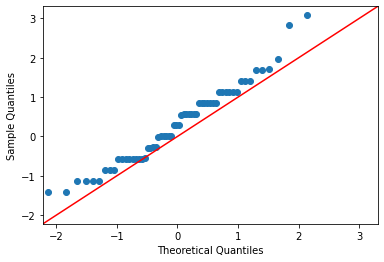

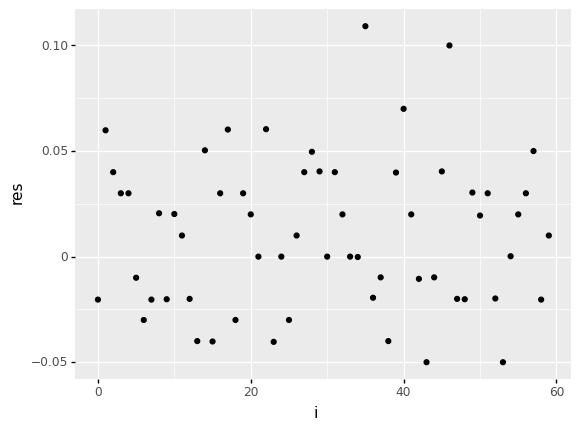

<P9:>


In [14]:
lm = showStats(ytm7y, ytm2y)
res = lm >> residuals(_, ytm7y, ytm2y)
res >> showResStats
res >> dm.plot.qq
res >> residualsPlot >> PP;

In [15]:
sm.OLS(ytm7y, sm.add_constant(ytm2y)).fit().summary() >> PP;

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     33.69
Date:                Mon, 07 Nov 2022   Prob (F-statistic):           2.86e-07
Time:                        07:52:21   Log-Likelihood:                 115.35
No. Observations:                  60   AIC:                            -226.7
Df Residuals:                      58   BIC:                            -222.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0110      0.005      2.369      0.0

beta:    [1.135]
t-stats: [26.533] [0.]
F-stat:  704.0 (5% is > nan), nan    R2: 0.923   predR2: [0.92  0.922 0.475]
res - mean: .4f  std: .4f  skew: .4f  kurt: .4f


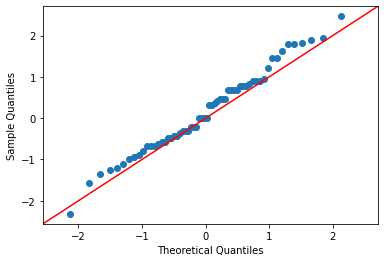

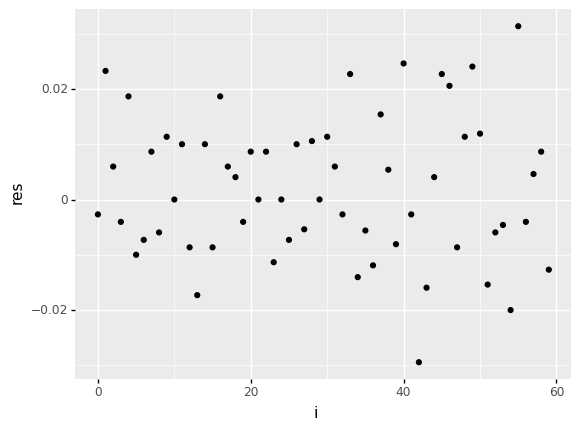

<P9:>


In [16]:
lm = showStats(ytm7y, ytm5y)
res = lm >> residuals(_, ytm7y, ytm5y)
res >> showResStats
res >> dm.plot.qq
res >> residualsPlot >> PP;

In [17]:
sm.OLS(ytm7y, sm.add_constant(ytm5y)).fit().summary() >> PP;

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     655.5
Date:                Mon, 07 Nov 2022   Prob (F-statistic):           2.67e-33
Time:                        07:52:22   Log-Likelihood:                 176.90
No. Observations:                  60   AIC:                            -349.8
Df Residuals:                      58   BIC:                            -345.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.283      0.2

beta:    [0.986]
t-stats: [25.771] [0.]
F-stat:  664.1 (5% is > nan), nan    R2: 0.918   predR2: [0.904 0.918 5.945]
res - mean: .4f  std: .4f  skew: .4f  kurt: .4f


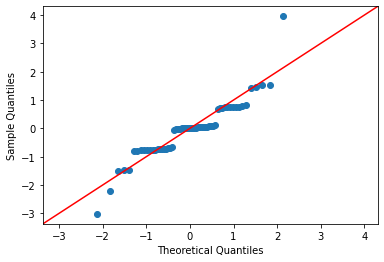

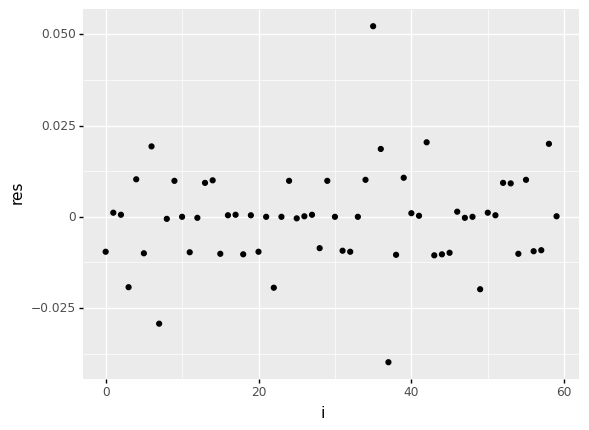

<P9:>


In [18]:
lm = showStats(ytm7y, ytm10y)
res = lm >> residuals(_, ytm7y, ytm10y)
res >> showResStats
res >> dm.plot.qq
res >> residualsPlot >> PP;

In [19]:
sm.OLS(ytm7y, sm.add_constant(ytm10y)).fit().summary() >> PP;

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     601.3
Date:                Mon, 07 Nov 2022   Prob (F-statistic):           2.65e-32
Time:                        07:52:22   Log-Likelihood:                 174.53
No. Observations:                  60   AIC:                            -345.1
Df Residuals:                      58   BIC:                            -340.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.002     -0.390      0.6

This one is a bit of a concern, we're getting some quantisation that we're not seeing in the regression against 5y. And the distribution is a bit squished.

beta:    [0.752]
t-stats: [9.547] [0.]
F-stat:  91.1 (5% is > nan), nan    R2: 0.607   predR2: [0.573 0.608 3.153]
res - mean: .4f  std: .4f  skew: .4f  kurt: .4f


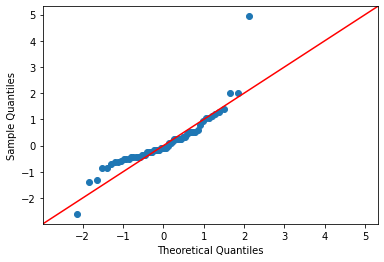

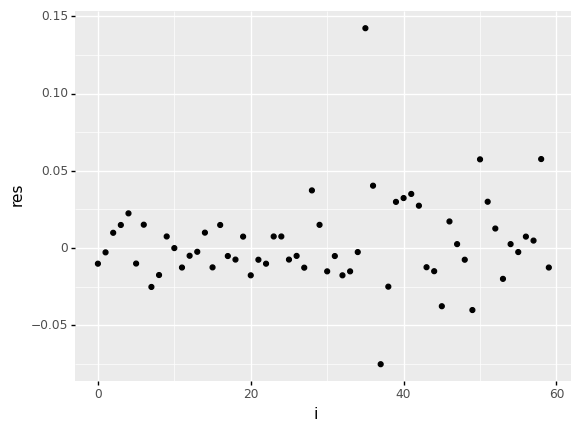

<P9:>


In [20]:
lm = showStats(ytm7y, ytm30y)
res = lm >> residuals(_, ytm7y, ytm30y)
res >> showResStats
res >> dm.plot.qq
res >> residualsPlot >> PP;

In [21]:
sm.OLS(ytm7y, sm.add_constant(ytm30y)).fit().summary() >> PP;

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     80.41
Date:                Mon, 07 Nov 2022   Prob (F-statistic):           1.50e-12
Time:                        07:52:22   Log-Likelihood:                 127.70
No. Observations:                  60   AIC:                            -251.4
Df Residuals:                      58   BIC:                            -247.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.004      0.894      0.3

beta:    [0.611 0.51 ]
t-stats: [10.478 10.051] [0. 0.]
F-stat:  999.3 (5% is > 4.0), 0.0    R2: 0.972   predR2: [0.968 0.972 2.451]
res - mean: .4f  std: .4f  skew: .4f  kurt: .4f


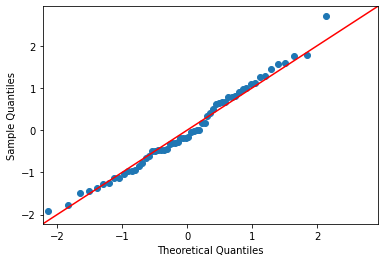

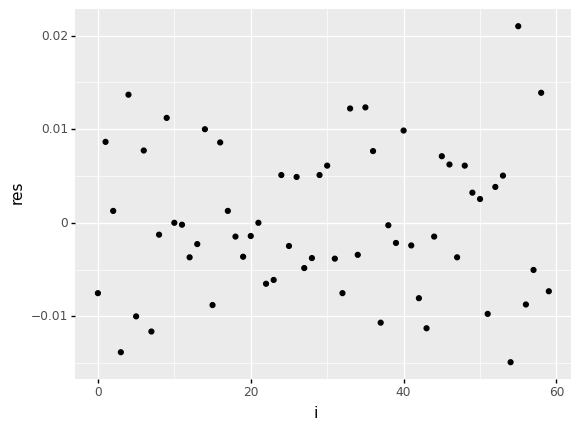

<P9:>


In [22]:
lm = showStats(ytm7y, ytm5y10y)
res = lm >> residuals(_, ytm7y, ytm5y10y)
res >> showResStats
res >> dm.plot.qq
res >> residualsPlot >> PP;

In [23]:
sm.OLS(ytm7y, sm.add_constant(ytm5y10y)).fit().summary() >> PP;

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     906.4
Date:                Mon, 07 Nov 2022   Prob (F-statistic):           6.25e-44
Time:                        07:52:22   Log-Likelihood:                 206.33
No. Observations:                  60   AIC:                            -406.7
Df Residuals:                      57   BIC:                            -400.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.721e-05      0.001      0.081      0.9

<br>

### PCA

#### NB: Using SVD to perform PCA

References - https://www.quora.com/What-is-the-difference-between-PCA-and-SVD and https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix

For a n x m panel matrix $P$, with n observations and m variables, let $C$ be the m x m covariance matrix $P ^ T P$. First let's consider the eigen decomposition of the covariance matrix - the resulting eigenvectors are the "principal components" and the eigen values the variance each eigen vector contributes to the overall variance.

A (nonzero) vector $v$ of dimension m is an eigenvector of a square m × m matrix $C$ if it satisfies a linear equation of the form:

$$
\begin{align}
C v = \lambda v
\end{align}
$$

Let $C$ be a square m × m matrix with m linearly independent eigenvectors $v_i$ (where i = 1, ..., m). Then $C$ can be factorized as


$$
C = V \Lambda  V^{-1}
$$


where $V$ is the square m × m matrix whose ith column is the eigenvector $v_i$ of $C$, and $\Lambda$ is the diagonal matrix whose diagonal elements are the corresponding eigenvalues, $\Lambda_ii = \lambda_i$.

$$
C V = V \Lambda
$$


Note that because  $P ^ T P$  is symmetric, $V$ is _**orthogonal**_ and the eigenvalues are all real-valued. This generates our "principal components" $V$ onto which we can project $P$ to get a set of uncorrelated variables:

$$P' = PV$$


Often we want $P'$ to be normalized, so dividing through by standard deviation, we get:

$$U = P' \Lambda ^{−1/2}$$ 

Substitute $PV$ for $P'$ and rearrange:

$$U = PV\Lambda^{-1/2}$$

$$P = U \Lambda^{1/2} V^T$$ 

i.e. the Singular Value Decomposition

<br>

#### PCA factors for the whole curve

[0.7754785  0.23860562 0.09956697 0.06988963 0.06686971 0.06057886
 0.059535   0.04020614]


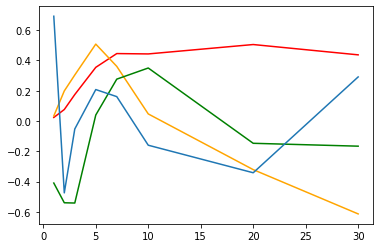

In [24]:
panel = usDiffs >> drop >> ['_1m', '_2m', '_3m', '_6m'] >> takePanel
vor, s = dm.linalg.pca(panel)
s >> PP
xs = [1, 2, 3, 5, 7, 10, 20, 30]
plt.plot(xs, vor[:,0], 'red')
plt.plot(xs, vor[:,1], 'orange')
plt.plot(xs, vor[:,2], 'green')
plt.plot(xs, vor[:,3]);

<br>

#### PCA factors for the hedge points

[0.5595266  0.19730383 0.07910155 0.06359349]


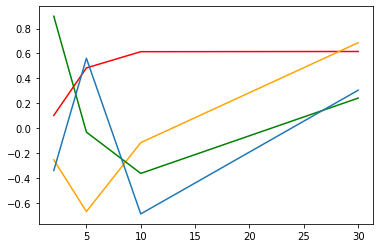

In [25]:
panel = usDiffs >> take >> ['_2y', '_5y', '_10y', '_30y']  >> takePanel
vor, s = dm.linalg.pca(panel)
s >> PP
xs = [2, 5, 10, 30]
plt.plot(xs, vor[:,0], 'red')
plt.plot(xs, vor[:,1], 'orange')
plt.plot(xs, vor[:,2], 'green')
plt.plot(xs, vor[:,3]);

Factor 1 seems fairly consistent, factors 2 and 3 flip signs. showing that the set of selected inputs impacts the analysis (even with the orientation algo).